In [1]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import numpy as np
import requests, json, math, random, folium
import matplotlib.pyplot as plt
from OSMPythonTools.nominatim import Nominatim
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
from census import Census
from us import states
from shapely.geometry import Point, MultiPoint, Polygon, LineString
from shapely.ops import nearest_points
from IPython.display import clear_output
%matplotlib inline

In [2]:
census_api_key='50eb4e527e6c123fc8230117b3b526e1055ee8da'
nominatim=Nominatim()
overpass=Overpass()
c=Census(census_api_key)
wgs='EPSG:4326'
merc='EPSG:3857'

In [3]:
ada={'state':'ID','county':'001','name':'Ada County, ID'}
king={'state':'WA','county':'033','name':'King County, WA'}
housing_tables={'pre_39':'B25034_011E',
                '1940-1949':'B25034_010E',
               '1950-1959':'B25034_009E',
               '1960-1969':'B25034_008E',
               '1970-1979':'B25034_007E',
               '1980-1989':'B25034_006E',
               '1990-1999':'B25034_005E',
               '2000-2009':'B25034_004E'}

In [4]:
def get_county_tracts(state, county_code):
    state_shapefile=gpd.read_file(states.lookup(state).shapefile_urls('tract'))
    county_shapefile=state_shapefile.loc[state_shapefile['COUNTYFP10']==county_code]
    return county_shapefile

In [5]:
def get_tract_population(state, county_code):
    population=pd.DataFrame(c.acs5.state_county_tract( 'B01003_001E', states.lookup(state).fips,'{}'.format(county_code),Census.ALL))
    population.rename(columns={'B01003_001E':'Total Population'}, inplace=True)
    population=population.loc[population['Total Population']!=0]
    return population

In [6]:
def geometrize_census_table_tracts(state,county_code,table,densityColumn=None,left_on='TRACTCE10',right_on='tract'):
    tracts=get_county_tracts(state, county_code)
    geometrized_tracts=tracts.merge(table,left_on=left_on,right_on=right_on)
    if densityColumn:
        geometrized_tracts['Density']=geometrized_tracts[densityColumn]/(geometrized_tracts['ALAND10']/2589988.1103)
    return geometrized_tracts

In [7]:
def get_housing_age_diversity(state,county):
    cols=list(housing_tables.keys())
    cols.insert(0,'TRACTCE10')
    cols.insert(1,'geometry')
    out=get_county_tracts(state,county)
    for key, value in housing_tables.items():
        out=out.merge(pd.DataFrame(c.acs5.state_county_tract(value,states.lookup(state).fips,county,Census.ALL)),left_on='TRACTCE10',right_on='tract')
        out.rename(columns={value:key},inplace=True)
    out=out[cols]
    out['Standard Deviation']=out.std(axis=1)
    return out

In [8]:
def osm_way_to_polygon(way):
    points=list()
    for p in range(len(way)):
        point=Point(way[p]['lon'],way[p]['lat'])
        points.append(point)
    poly=Polygon([[p.x, p.y] for p in points])
    return poly

In [9]:
def osm_way_to_line(way):
    points=list()
    for p in range(len(way)):
        point=Point(way[p]['lon'],way[p]['lat'])
        points.append(point)
    poly=LineString([[p.x, p.y] for p in points])
    return poly

In [10]:
def osm_query(area,elementType,feature_type,feature_name=None,poly_to_point=True):
    if feature_name:
        q=overpassQueryBuilder(area=nominatim.query(area).areaId(),
                                    elementType=elementType,
                                    selector='"{ft}"="{fn}"'.format(ft=feature_type,fn=feature_name),
                                    out='body',includeGeometry=True)
    else:
        q=overpassQueryBuilder(area=nominatim.query(area).areaId(),
                                    elementType=elementType,
                                    selector='"{ft}"'.format(ft=feature_type),
                                    out='body',includeGeometry=True)
    if len(overpass.query(q).toJSON()['elements'])>0:
        out=pd.DataFrame(overpass.query(q).toJSON()['elements'])
        if elementType=='node':
            out=gpd.GeoDataFrame(out,geometry=gpd.points_from_xy(out['lon'],out['lat']),crs=wgs)
            out=out.to_crs(merc)
        if elementType=='way':
            geometry=[]
            for i in out.geometry:
                geo=osm_way_to_polygon(i)
                geometry.append(geo)
            out.geometry=geometry
            out=gpd.GeoDataFrame(out,crs=wgs)
            out=out.to_crs(merc)
            if poly_to_point:
                out.geometry=out.geometry.centroid
        out=pd.concat([out.drop(['tags'],axis=1),out['tags'].apply(pd.Series)],axis=1)
        if elementType=='relation':
            out=pd.concat([out.drop(['members'],axis=1),out['members'].apply(pd.Series)[0].apply(pd.Series)],axis=1)
            geometry=[]
            for index, row in out.iterrows():
                row['geometry']=osm_way_to_polygon(row['geometry'])
                geometry.append(row['geometry'])
            out.geometry=geometry
            out=gpd.GeoDataFrame(out,crs=wgs)
            out=out.to_crs(merc)
            if poly_to_point:
                out.geometry=out.geometry.centroid
        out=out[['name','id','geometry']]
        if feature_name:
            out['type']= feature_name
        else:
            out['type']= feature_type
    else:
        out=pd.DataFrame(columns=['name','id','geometry','type'])
    return out

In [11]:
def combine_osm_features(name,feature_type,feature_name=None):
    df=pd.concat([osm_query(name,'node',feature_type,feature_name),osm_query(name,'way',feature_type,feature_name)])
    return df

In [12]:
def get_key_features(name):
    df=pd.concat([combine_osm_features(name,'office'),
                 combine_osm_features(name,'leisure','park')])
    amenities=['bar','restaurant','cafe','library','school','bank','clinic','hospital','pharmacy','post_office']
    shops=['supermarket','hardware','doityourself']
    for a in amenities:
        df=pd.concat([df,combine_osm_features(name,'amenity',a)])
    for s in shops:
        df=pd.concat([df,combine_osm_features(name,'shop',s)])
    df=df.replace('doityourself','hardware')
    return gpd.GeoDataFrame(df,crs=merc)

In [13]:
def create_point_grid(poly,nrows=100,ncols=100,crs='EPSG:3857'):
    cols=np.linspace(poly.total_bounds[0],poly.total_bounds[2],ncols)
    rows=np.linspace(poly.total_bounds[1],poly.total_bounds[3],nrows)
    points=[]
    for x in cols:
        for y in rows:
            points.append(Point(x,y))
    grid=gpd.GeoDataFrame({'geometry':points},crs=crs)
    grid=gpd.overlay(grid,poly,how='intersection')
    return grid

In [14]:
def get_nearby_features(grid,location,feature_type,output_name,feature_name=None,nearby_distance=.5,crs='EPSG:3857'):
    grid=grid.to_crs(crs)
    dests=query_osm(location,feature_type,feature_name).to_crs(crs)
    colname='nearby_{}'.format(output_name)
    out=gpd.GeoDataFrame()
    i=1
    for index, row in grid.iterrows():
        clear_output(wait=True)
        point = row.geometry
        q,n = nearest_points(point,dests.geometry.unary_union)
        row['points']=len(grid.loc[grid['TRACTCE10']==row['TRACTCE10']])
        if (point.distance(n)/1609.341)<nearby_distance:
            row['nearby']=True
        else:
            row['nearby']=False
        out=out.append(row)
        print('calculating {}, {}% complete'.format(output_name,round(((i/len(grid))*100),1)))
        i+=1
    out=out.groupby('TRACTCE10',as_index=False).apply(lambda x: x['nearby'].sum()/len(x))
    out.columns=['TRACTCE10',colname]
    return out

In [15]:
def score_streets(gdf):
    out=gpd.GeoDataFrame()
    i=1
    for index, row in gdf.iterrows():
        try:
            clear_output(wait=True)
            g=ox.graph_from_polygon(row['geometry'],network_type='walk')
            stats=ox.stats.basic_stats(g)
            row['street_score']=stats['street_length_avg']/stats['streets_per_node_avg']
            print('{}% complete'.format(round(((i/len(gdf))*100),2)))
            ox.plot_graph(g,node_size=0)
            out=out.append(row)
            i+=1
        except:
            continue
    return out

In [16]:
# def calculate_nearbyness(grid,location):
#     print('calcualting offices')
#     nearby_df=get_nearby_features(grid,location,'office','offices')
#     print('calculating parks')
#     nearby_df=nearby_df.merge(get_nearby_features(grid,location='Ada County',feature_type='leisure',feature_name='park',output_name='parks'))
#     amenities=['bar','restaurant','cafe','pub','library','school','bank','clinic','hospital','pharmacy','post_office']
#     shops=['supermarket','hardware','doityourself']
#     for a in amenities:
#         nearby_df=nearby_df.merge(get_nearby_features(grid,location='Ada County',feature_type='amenity',feature_name=a,output_name=a))
#     for s in shops:
#         nearby_df=nearby_df.merge(get_nearby_features(grid,location='Ada County',feature_type='shop',feature_name=s,output_name=s))
#     nearby_df['nearbyness']=nearby_df.mean(axis=1)
#     return nearby_df

In [17]:
def random_sample_points(poly,npoints=10,tract_col='TRACTCE10'):
    min_x,min_y,max_x,max_y=poly.geometry.total_bounds
    points=[]
    tracts=[]
    i=0
    while i < npoints:
        point=Point(random.uniform(min_x,max_x),random.uniform(min_y,max_y))
        if poly.geometry.contains(point).iloc[0]:
            points.append(point)
            tracts.append(poly[tract_col].iloc[0])
            i+=1
    out=gpd.GeoDataFrame({tract_col:tracts,'geometry':points},crs=poly.crs)
    return out

In [18]:
def tract_sampler(gdf):
    points_gdf=gpd.GeoDataFrame()
    for index, row in gdf.iterrows():
        points=random_sample_points(row)
        points_gdf=points_gdf.append(points)
    points_gdf=points_gdf.to_crs(merc)
    return points_gdf

In [19]:
# def calculate_nearbyness(gdf,feature_gdf, buffer_dist=1000):
#     out=gpd.GeoDataFrame()
#     for index, row in gdf.iterrows():
#         row.geometry=row.geometry.buffer(1000)
#         right=gpd.GeoDataFrame(pd.DataFrame(row).T,crs=merc,geometry='geometry')
#         df=gpd.sjoin(feature_gdf,right)
#         gb=df.groupby(['TRACTCE10','type'],as_index=False).count()
#         out=out.append(gb)
#     out=pd.pivot_table(out,values='name',index='TRACTCE10',columns='type')
#     out['nearby']=(out.notnull().sum(axis=1))/14
#     return out

In [20]:
def calculate_nearbyness_tract(tract,features,npoints=10,buffer_dist=1000):
    points=random_sample_points(tract,npoints).to_crs(merc)
    points.geometry=points.geometry.buffer(buffer_dist)
    cols=features['type'].unique().tolist()
    out=gpd.GeoDataFrame()
    i=1
    for index, row in points.iterrows():
        row['point_id']=i
        r=gpd.GeoDataFrame(pd.DataFrame(row).T,crs=points.crs,geometry='geometry').to_crs(merc)
        gdf=gpd.overlay(features,r,how='intersection')
        out=out.append(gdf)
        i+=1
    out=out.groupby(['point_id','type','TRACTCE10'],as_index=False).count()
    out=out.pivot(['point_id','TRACTCE10'],'type','name')
    out['nearby']=(out.notnull().sum(axis=1))/len(cols)
    out=pd.DataFrame(out.mean(axis=0,numeric_only=True)).T
    out.insert(0,'tract',tract['TRACTCE10'].iloc[0],True)
    return out

In [21]:
def calculate_nearbyness(gdf,features,npoints=10,buffer_dist=1000):
    out=pd.DataFrame()
    cols=features['type'].unique().tolist()
    for index, row in gdf.iterrows():
        r=gpd.GeoDataFrame(pd.DataFrame(row).T,crs=gdf.crs,geometry='geometry')
        near=calculate_nearbyness_tract(r,features,npoints,buffer_dist)
        out=out.append(near)
    cols.insert(0,'tract')
    cols.append('nearby')
    out.drop(out.columns.difference(cols),1,inplace=True)
    return out

In [22]:
ada_tracts=get_county_tracts(ada['state'],ada['county']).to_crs(merc)
ada_parking=osm_query('Ada County, ID','way','amenity','parking',poly_to_point=False)
ada_tracts_parking=gpd.overlay(ada_tracts,ada_parking,how='symmetric_difference')

In [23]:
king_tracts=get_county_tracts(king['state'],king['county']).to_crs(merc)
king_parking=osm_query('king County, WA','way','amenity','parking',poly_to_point=False)
king_tracts_parking=gpd.overlay(king_tracts,king_parking,how='symmetric_difference')

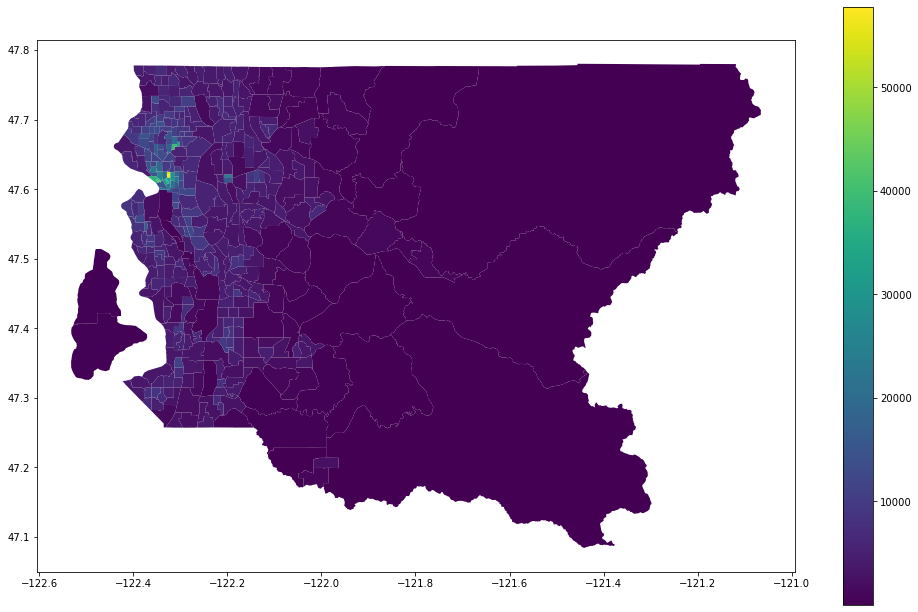

In [24]:
king_pop_tracts=geometrize_census_table_tracts(king['state'],king['county'],get_tract_population(king['state'],king['county']),'Total Population')
king_pop_tracts.plot(column='Density',legend=True,figsize=(17,11))
plt.savefig('king_density.png',transparent=True,bbox_inches='tight')

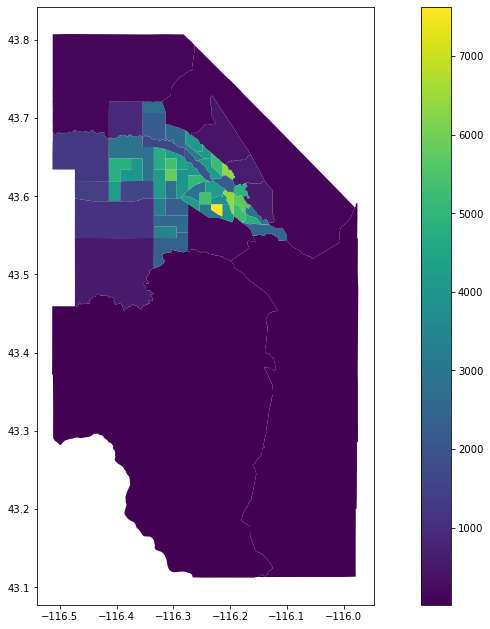

In [25]:
ada_pop_tracts=geometrize_census_table_tracts(ada['state'],ada['county'],get_tract_population(ada['state'],ada['county']),'Total Population')
ada_density_plot=ada_pop_tracts.plot(column='Density',legend=True,figsize=(17,11))
plt.savefig('ada_density.png',transparent=True,bbox_inches='tight')

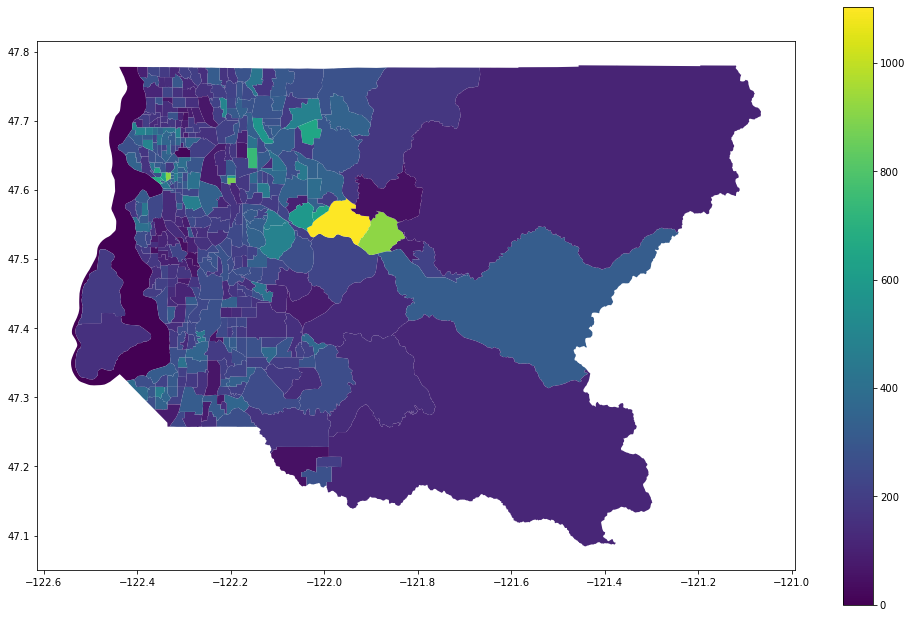

In [26]:
king_housing=get_housing_age_diversity(king['state'],king['county'])
king_housing.plot(column='Standard Deviation',legend=True,figsize=(17,11))
plt.savefig('king_housing.png',transparent=True,bbox_inches='tight')

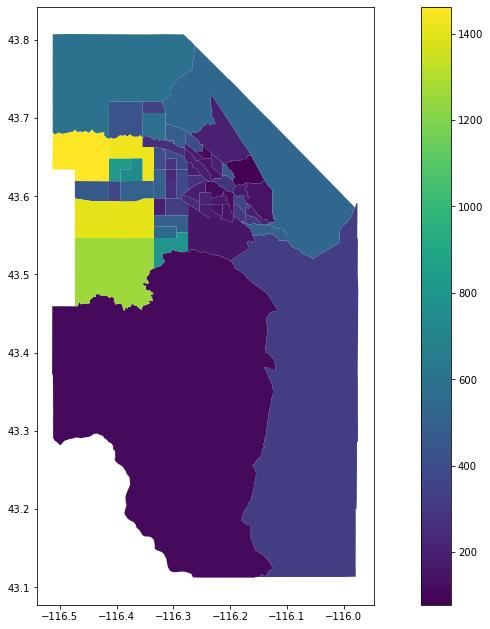

In [27]:
ada_housing=get_housing_age_diversity(ada['state'],ada['county'])
ada_housing.plot(column='Standard Deviation',legend=True,figsize=(17,11))
plt.savefig('ada_housing.png',transparent=True,bbox_inches='tight')

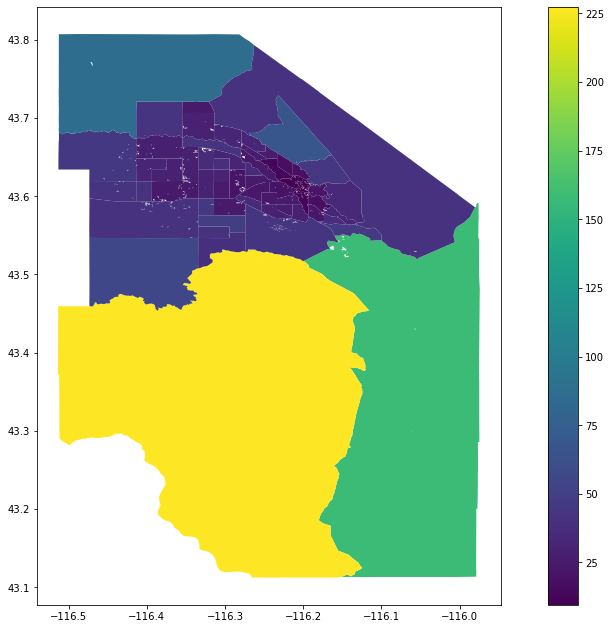

In [28]:
ada_street_scores=score_streets(ada_tracts_parking.to_crs(wgs))
ada_street_scores.plot(column='street_score',legend=True,figsize=(17,11))
plt.savefig('ada_streets.png',transparent=True,bbox_inches='tight')

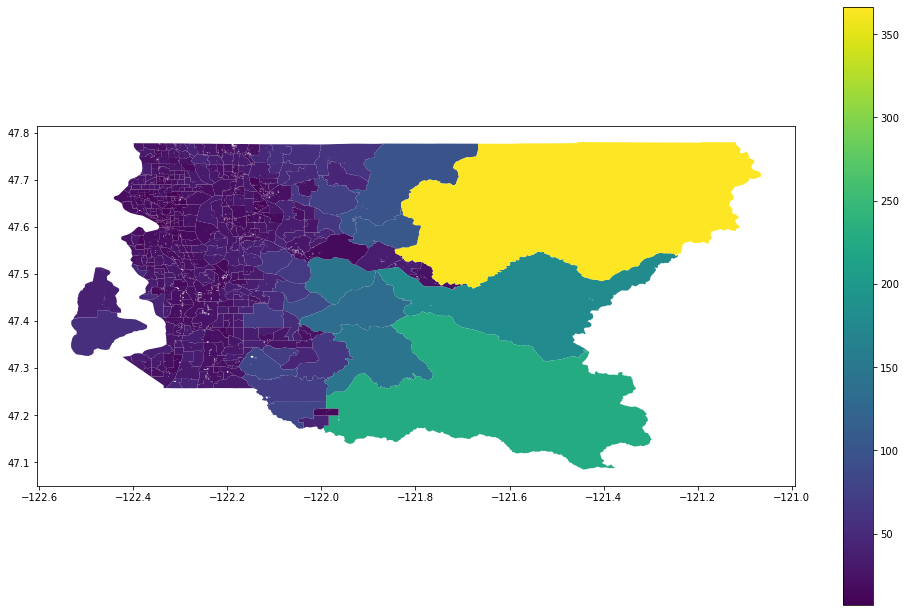

In [29]:
king_street_scores=score_streets(king_tracts_parking.to_crs(wgs))
king_street_scores.plot(column='street_score',legend=True,figsize=(17,11))
plt.savefig('king_streets.png',transparent=True,bbox_inches='tight')

<AxesSubplot:>

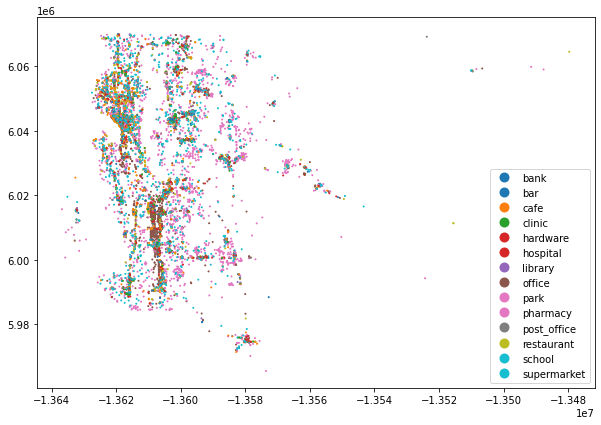

In [30]:
king_features=get_key_features(king['name']).to_crs(merc)
king_features.plot(markersize=1,figsize=(10,10),column='type',legend=True)

<AxesSubplot:>

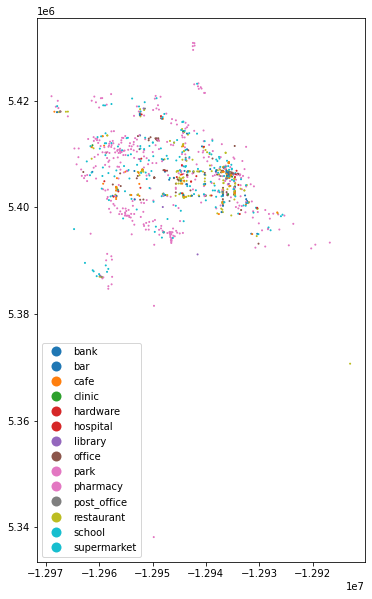

In [31]:
ada_features=get_key_features(ada['name']).to_crs(merc)
ada_features.plot(markersize=1,figsize=(10,10),column='type',legend=True)

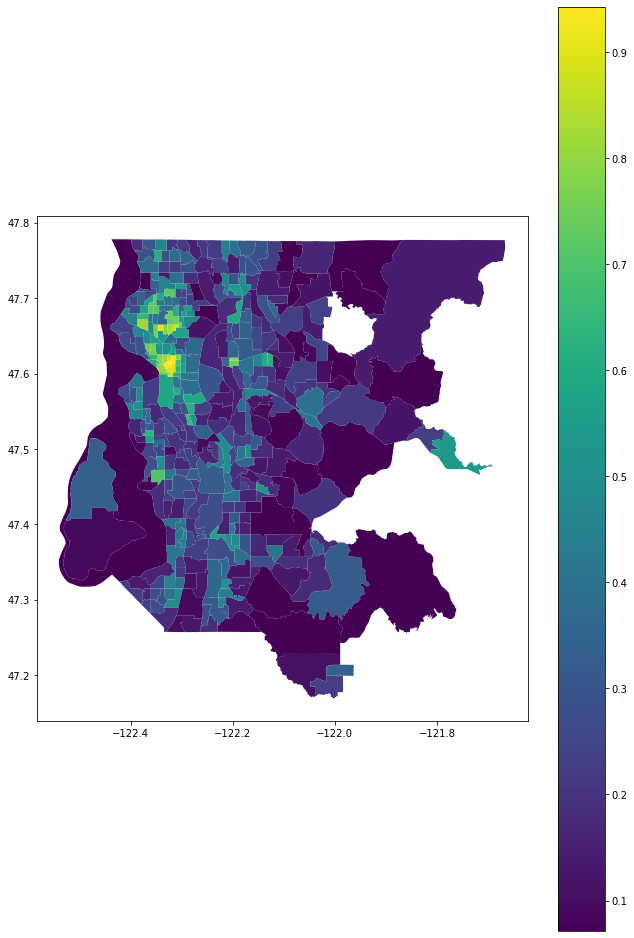

In [32]:
king_nearby=calculate_nearbyness(king_tracts,king_features)
geometrize_census_table_tracts(king['state'],king['county'],king_nearby).plot(column='nearby',legend=True,figsize=(11,17))
plt.savefig('king_nearby.png',transparent=True,bbox_inches='tight')

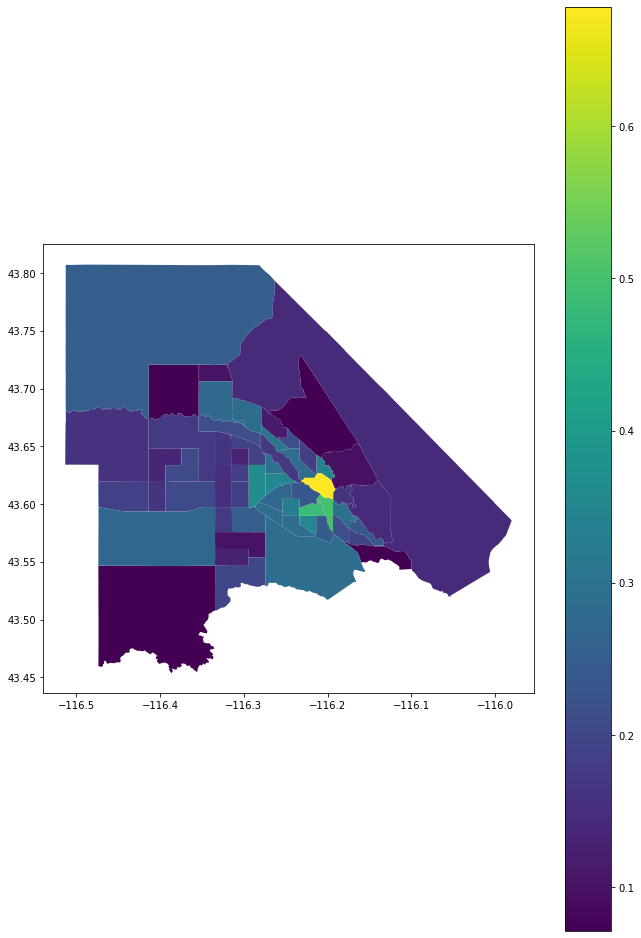

In [33]:
ada_nearby=calculate_nearbyness(ada_tracts,ada_features)
geometrize_census_table_tracts(ada['state'],ada['county'],ada_nearby).plot(column='nearby',legend=True,figsize=(11,17))
plt.savefig('ada_nearby.png',transparent=True,bbox_inches='tight')

In [34]:
def jane_jacobs_index(density,housing_age,mix,streets,merge_col='TRACTCE10'):
    df=density.merge(housing_age,on=merge_col).merge(mix,on='tract').merge(streets,on=merge_col)
    df['street_rank']=df['street_score'].rank(ascending=True,na_option='bottom')
    df['nearby_rank']=df['nearby'].rank(ascending=False,na_option='top')
    df['housing_rank']=df['Standard Deviation'].rank(ascending=True,na_option='bottom')
    df['density_rank']=df['Density'].rank(ascending=False,na_option='top')
    df=df[['TRACTCE10','street_rank','nearby_rank','housing_rank','density_rank']]
    df['JJI']=df.mean(axis=1)
    return(df)

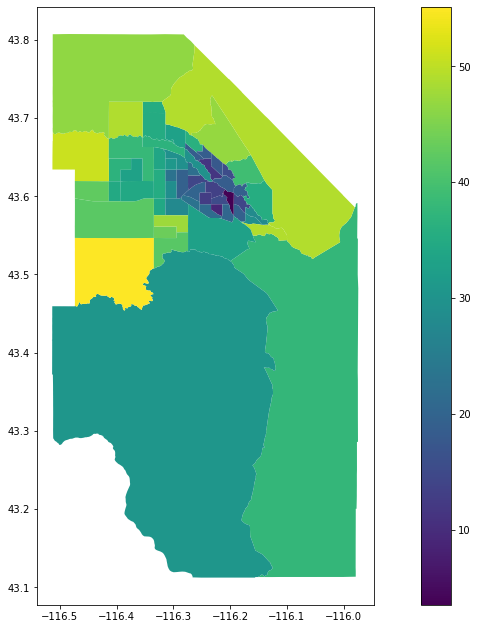

In [35]:
ada_jji=jane_jacobs_index(ada_pop_tracts,ada_housing,ada_nearby,ada_street_scores)
ada_jji=geometrize_census_table_tracts(ada['state'],ada['county'],ada_jji,right_on='TRACTCE10')
ada_jji_plot=ada_jji.plot(column='JJI',legend=True, figsize=(17,11))
plt.savefig('ada_jji.png',transparent=True,bbox_inches='tight')

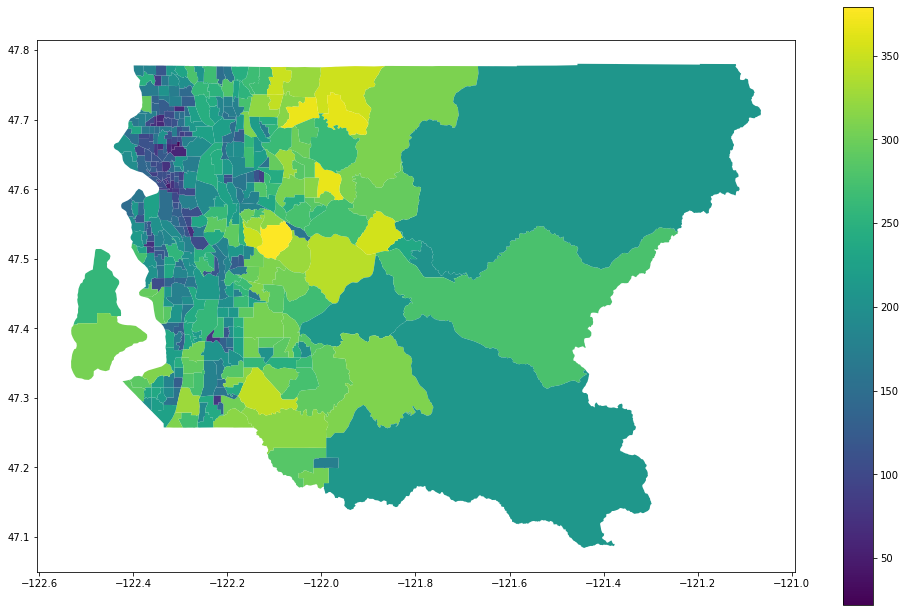

In [36]:
king_jji=jane_jacobs_index(king_pop_tracts,king_housing,king_nearby,king_street_scores)
king_jji=geometrize_census_table_tracts(king['state'],king['county'],king_jji,right_on='TRACTCE10')
king_jji_plot=king_jji.plot(column='JJI',legend=True, figsize=(17,11))
plt.savefig('king_jji.png',transparent=True,bbox_inches='tight')

In [38]:
ada_jji_json=ada_jji.to_file("ada_jji.geojson", driver='GeoJSON')

In [39]:
king_jji_json=king_jji.to_file("king_jji.geojson", driver='GeoJSON')

In [44]:
ada_jji.head()

,STATEFP10,COUNTYFP10,TRACTCE10,GEOID10,NAME10,NAMELSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry,street_rank,nearby_rank,housing_rank,density_rank,JJI
0,16,001,000803,16001000803,8.03,Census Tract 8.03,G5020,S,2361317,267,+43.5698099,-116.1617483,"POLYGON ((-116.14030 43.56412, -116.13976 43.5...",39.0,33.0,31.0,13.0,29.00
1,16,001,010332,16001010332,103.32,Census Tract 103.32,G5020,S,7740674,14454,+43.6358472,-116.3985507,"POLYGON ((-116.41367 43.62935, -116.41367 43.6...",31.0,49.0,55.0,12.0,36.75
2,16,001,000400,16001000400,4,Census Tract 4,G5020,S,3684047,289381,+43.6356426,-116.2349499,"POLYGON ((-116.24914 43.64742, -116.24797 43.6...",2.0,16.0,8.0,20.0,11.50
3,16,001,002222,16001002222,22.22,Census Tract 22.22,G5020,S,5246353,5444,+43.5536497,-116.3132875,"POLYGON ((-116.33439 43.54903, -116.33437 43.5...",45.0,51.0,50.0,28.0,43.50
4,16,001,010334,16001010334,103.34,Census Tract 103.34,G5020,S,13323635,13812,+43.6070076,-116.4458141,"POLYGON ((-116.41362 43.60844, -116.41362 43.6...",46.0,35.0,42.0,47.0,42.50


In [82]:
ada_map=folium.Map(location=[43.4595119,-116.524329],zoom_start=10)
folium.Choropleth(geo_data=ada_jji,
                  data=ada_jji,
                  columns=['TRACTCE10','JJI'],
                  fill_color='YlGnBu',
                  key_on='feature.properties.TRACTCE10',
                  highlight=True,
                  name='Jane Jacobs Index',
                  legend_name='Jane Jacobs Index',
                  line_weight=.2).add_to(ada_map)
folium.Choropleth(geo_data=ada_jji,
                  data=ada_jji,
                  columns=['TRACTCE10','street_rank'],
                  fill_color='YlGnBu',
                  key_on='feature.properties.TRACTCE10',
                  highlight=True,
                  show=False,
                  name='Street Rank',
                  legend_name='Street Rank',
                  line_weight=.2).add_to(ada_map)
folium.Choropleth(geo_data=ada_jji,
                  data=ada_jji,
                  columns=['TRACTCE10','nearby_rank'],
                  fill_color='YlGnBu',
                  key_on='feature.properties.TRACTCE10',
                  highlight=True,
                  show=False,
                  name='Nearby Rank',
                  legend_name='Nearby Rank',
                  line_weight=.2).add_to(ada_map)
folium.Choropleth(geo_data=ada_jji,
                  data=ada_jji,
                  columns=['TRACTCE10','housing_rank'],
                  fill_color='YlGnBu',
                  key_on='feature.properties.TRACTCE10',
                  highlight=True,
                  show=False,
                  name='Housing Age Rank',
                  legend_name='Housing Age Rank',
                  line_weight=.2).add_to(ada_map)
folium.Choropleth(geo_data=ada_jji,
                  data=ada_jji,
                  columns=['TRACTCE10','density_rank'],
                  fill_color='YlGnBu',
                  key_on='feature.properties.TRACTCE10',
                  highlight=True,
                  show=False,
                  name='Density Rank',
                  legend_name='Density Rank',
                  line_weight=.2).add_to(ada_map)
folium.LayerControl(collapsed=False).add_to(ada_map)
ada_map.save('ada_map.html')

In [77]:
king_map=folium.Map(location=[47.4310271,-122.3638018],zoom_start=9)
folium.Choropleth(geo_data=king_jji,
                  data=king_jji,
                  columns=['TRACTCE10','JJI'],
                  fill_color='YlGnBu',
                  key_on='feature.properties.TRACTCE10',
                  highlight=True,
                  name='Jane Jacobs Index',
                  legend_name='Jane Jacobs Index',
                  line_weight=.2).add_to(king_map)
folium.Choropleth(geo_data=king_jji,
                  data=king_jji,
                  columns=['TRACTCE10','street_rank'],
                  fill_color='YlGnBu',
                  key_on='feature.properties.TRACTCE10',
                  highlight=True,
                  show=False,
                  name='Street Rank',
                  legend_name='Street Rank',
                  line_weight=.2).add_to(king_map)
folium.Choropleth(geo_data=king_jji,
                  data=king_jji,
                  columns=['TRACTCE10','nearby_rank'],
                  fill_color='YlGnBu',
                  key_on='feature.properties.TRACTCE10',
                  highlight=True,
                  show=False,
                  name='Nearby Rank',
                  legend_name='Nearby Rank',
                  line_weight=.2).add_to(king_map)
folium.Choropleth(geo_data=king_jji,
                  data=king_jji,
                  columns=['TRACTCE10','housing_rank'],
                  fill_color='YlGnBu',
                  key_on='feature.properties.TRACTCE10',
                  highlight=True,
                  show=False,
                  name='Housing Age Rank',
                  legend_name='Housing Age Rank',
                  line_weight=.2).add_to(king_map)
folium.Choropleth(geo_data=king_jji,
                  data=king_jji,
                  columns=['TRACTCE10','density_rank'],
                  fill_color='YlGnBu',
                  key_on='feature.properties.TRACTCE10',
                  highlight=True,
                  show=False,
                  name='Density Rank',
                  legend_name='Density Rank',
                  line_weight=.2).add_to(king_map)
folium.LayerControl(collapsed=False).add_to(king_map)
king_map.save('king_map.html')